In [3]:
# %pip install gym

import numpy as np
import matplotlib.pyplot as plt
import gym

np.random.seed(42)

In [4]:
class PolicyNetwork:
    def __init__(self, state_size=4, action_size=2, lr=0.01):
        self.lr = lr
        self.W1 = np.random.randn(state_size, 16) * 0.1
        self.b1 = np.zeros(16)
        self.W2 = np.random.randn(16, action_size) * 0.1
        self.b2 = np.zeros(action_size)
    
    def forward(self, state):
        h = np.maximum(0, np.dot(state, self.W1) + self.b1)  # ReLU
        logits = np.dot(h, self.W2) + self.b2
        probs = self.softmax(logits)
        return probs, h, logits
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / np.sum(exp_x)
    
    def get_action(self, state):
        probs, _, _ = self.forward(state)
        action = np.random.choice(len(probs), p=probs)
        return action, probs
    
    def update(self, states, actions, rewards):
        returns = self.calculate_returns(rewards)
        
        for state, action, G in zip(states, actions, returns):
            probs, h, logits = self.forward(state)
            
            # Policy gradient
            d_logits = probs.copy()
            d_logits[action] -= 1
            d_logits *= G
            
            # Backprop
            dW2 = np.outer(h, d_logits)
            db2 = d_logits
            
            dh = np.dot(d_logits, self.W2.T)
            dh[h <= 0] = 0  # ReLU derivative
            
            dW1 = np.outer(state, dh)
            db1 = dh
            
            # Update weights
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1
    
    def calculate_returns(self, rewards, gamma=0.99):
        returns = []
        G = 0
        for reward in reversed(rewards):
            G = reward + gamma * G
            returns.insert(0, G)
        return returns

In [5]:
def train_policy_gradient(env, policy, episodes=1000):
    scores = []
    
    for episode in range(episodes):
        state = env.reset()
        states, actions, rewards = [], [], []
        
        while True:
            action, _ = policy.get_action(state)
            next_state, reward, done, _ = env.step(action)
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            
            state = next_state
            
            if done:
                break
        
        policy.update(states, actions, rewards)
        scores.append(sum(rewards))
        
        if episode % 100 == 0:
            avg_score = np.mean(scores[-100:])
            print(f"Episode {episode}: Average Score = {avg_score:.1f}")
    
    return scores

c:\Users\Dnyaneshwari\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0: Average Score = 14.0
Episode 100: Average Score = 23.6
Episode 100: Average Score = 23.6
Episode 200: Average Score = 45.1
Episode 200: Average Score = 45.1
Episode 300: Average Score = 20.5
Episode 300: Average Score = 20.5
Episode 400: Average Score = 18.3
Episode 400: Average Score = 18.3
Episode 500: Average Score = 25.2
Episode 500: Average Score = 25.2
Episode 600: Average Score = 26.0
Episode 600: Average Score = 26.0
Episode 700: Average Score = 23.4
Episode 700: Average Score = 23.4


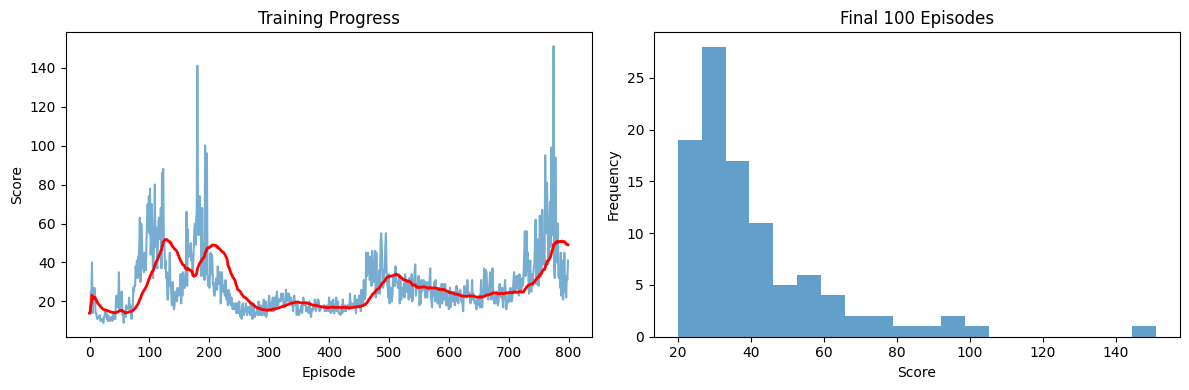

Final average score: 41.1


In [7]:
# Train the agent
env = gym.make('CartPole-v1')
policy = PolicyNetwork(state_size=4, action_size=2, lr=0.01)

# Helper to ensure state is always a numpy array
def get_obs(state):
	if isinstance(state, tuple):
		return np.asarray(state[0])
	return np.asarray(state)

# Patch train_policy_gradient to handle tuple states
def train_policy_gradient(env, policy, episodes=1000):
	scores = []
	
	for episode in range(episodes):
		state = env.reset()
		state = get_obs(state)
		states, actions, rewards = [], [], []
		
		while True:
			action, _ = policy.get_action(state)
			step_result = env.step(action)
			if isinstance(step_result, tuple) and len(step_result) == 5:
				next_state, reward, terminated, truncated, _ = step_result
				done = terminated or truncated
			else:
				next_state, reward, done, _ = step_result
			next_state = get_obs(next_state)
			
			states.append(state)
			actions.append(action)
			rewards.append(reward)
			
			state = next_state
			
			if done:
				break
		
		policy.update(states, actions, rewards)
		scores.append(sum(rewards))
		
		if episode % 100 == 0:
			avg_score = np.mean(scores[-100:])
			print(f"Episode {episode}: Average Score = {avg_score:.1f}")
	
	return scores

scores = train_policy_gradient(env, policy, episodes=800)

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(scores, alpha=0.6)
window = 50
moving_avg = [np.mean(scores[max(0, i-window):i+1]) for i in range(len(scores))]
plt.plot(moving_avg, color='red', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Training Progress')

plt.subplot(1, 2, 2)
recent_scores = scores[-100:]
plt.hist(recent_scores, bins=20, alpha=0.7)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Final 100 Episodes')

plt.tight_layout()
plt.show()

print(f"Final average score: {np.mean(scores[-100:]):.1f}")

In [9]:
# Test the trained policy
def test_policy(env, policy, episodes=5):
    for episode in range(episodes):
        state = env.reset()
        state = get_obs(state)
        total_reward = 0
        steps = 0
        
        while steps < 500:
            action, probs = policy.get_action(state)
            step_result = env.step(action)
            if isinstance(step_result, tuple) and len(step_result) == 5:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = step_result
            next_state = get_obs(next_state)
            total_reward += reward
            steps += 1
            state = next_state
            
            if done:
                break
        
        print(f"Test Episode {episode + 1}: Score = {total_reward}, Steps = {steps}")

test_policy(env, policy)
env.close()

Test Episode 1: Score = 30.0, Steps = 30
Test Episode 2: Score = 35.0, Steps = 35
Test Episode 3: Score = 45.0, Steps = 45
Test Episode 4: Score = 31.0, Steps = 31
Test Episode 5: Score = 39.0, Steps = 39
